In [24]:
# Import the standard modules
import sqlite3
import spiceypy

# Import the installed modules
import pandas as pd
import numpy as np

# Import matplotlib for plotting
from matplotlib import pyplot as plt

# Import scipy for the Kernel Density Estimator functionality
from scipy import stats

In [25]:
# Connect to the comet database. This database has been created in tutorial
# part 7, however, due to its small size the database is uploaded on GitHub
con = sqlite3.connect('../databases/comets/mpc_comets.db')

# Set a cursor
cur = con.cursor()

# Create a pandas dataframe that contains the name of the comet (needed later),
# the semi-major axis, inclination and eccentricity
# for P type ...
p_type_df = pd.read_sql('SELECT NAME, SEMI_MAJOR_AXIS_AU, INCLINATION_DEG, ' \
                        'ECCENTRICITY FROM comets_main WHERE ORBIT_TYPE="P"', \
                        con)

# ... and C type comets. For this type: set the eccentricity smaller 1 (bound
# orbits)
c_type_df = pd.read_sql('SELECT NAME, SEMI_MAJOR_AXIS_AU, INCLINATION_DEG, ' \
                        'ECCENTRICITY FROM comets_main WHERE ORBIT_TYPE="C" ' \
                        'AND ECCENTRICITY<1', con)

In [26]:
# The Tisserand parameter will help us to distinguish between Jupiter Family
# Comets (JFCs) and Non-JFCss more easily. For this parameter (next block) we
# need the semi-major axis of Jupiter

# Clear any previously loaded kernels
spiceypy.kclear()

# Load the SPICE kernel meta file
kernels = [
    '../kernels/pck/gm_de431.tpc',
    '../kernels/spk/de432s.bsp',
    '../kernels/lsk/naif0012.tls'
]

for kernel in kernels:
    spiceypy.furnsh(kernel)

print("Total Kernels Loaded:", spiceypy.ktotal("ALL"))

# Set any Ephemeris time (ET)
sample_et = spiceypy.utc2et('2000-001T00:00:00')

# Compute the state vector of Jupiter in ECLIPJ2000 (Jupiter (599) is not
# available in the kernel, we use the barycentre (5))
state_vec_jupiter, _ = spiceypy.spkgeo(targ=5, \
                                       et=sample_et, \
                                       ref='ECLIPJ2000', \
                                       obs=10)

# Get the G*M value of the Sun
_, gm_sun_pre = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
gm_sun = gm_sun_pre[0]

# Compute the orbital elements of Jupiter
orb_elem_jupiter = spiceypy.oscltx(state_vec_jupiter, sample_et, gm_sun)

# Get the semi-major axis value
a_jupiter_km = orb_elem_jupiter[-2]

# Convert the value from km to AU
a_jupiter_au = spiceypy.convrt(a_jupiter_km, 'km', 'AU')

Total Kernels Loaded: 3


In [27]:
# Define a lambda function for the Tisserand parameter, a, i and e are the
# input parameters semi-major axis, inclination and eccentricity, respectively
tisr_jup = lambda a, i, e: (a_jupiter_au / a) + 2 * np.cos(i) \
                           * np.sqrt((a / a_jupiter_au) * (1 - (e**2.0)))

# Create a new dataframe columns that contains the Tisserand parameter
p_type_df.loc[:, 'TISSERAND_JUP'] = \
    p_type_df.apply(lambda x: (tisr_jup(a=x['SEMI_MAJOR_AXIS_AU'], \
                                        i=np.radians(x['INCLINATION_DEG']), \
                                        e=x['ECCENTRICITY'])), axis=1)

c_type_df.loc[:, 'TISSERAND_JUP'] = \
    c_type_df.apply(lambda x: (tisr_jup(a=x['SEMI_MAJOR_AXIS_AU'], \
                               i=np.radians(x['INCLINATION_DEG']), \
                               e=x['ECCENTRICITY'])), axis=1)

In [28]:
# Print some descriptive statistics of the P type comets
p_type_df["TISSERAND_JUP"].describe()

count    830.000000
mean       2.695519
std        0.496206
min       -0.641388
25%        2.635940
50%        2.784713
75%        2.924521
max        3.663176
Name: TISSERAND_JUP, dtype: float64

In [29]:
# Compute the percentage of Jupiter-Family Comets (JFCs) based on P types
perc_p_type_jfcs = len(p_type_df.loc[(p_type_df["TISSERAND_JUP"] > 2) \
                                      & (p_type_df["TISSERAND_JUP"] < 3)]) \
                    / len(p_type_df.index) * 100
perc_p_type_jfcs = round(perc_p_type_jfcs, 0)

# Print how many P comets have a Tisserand parameter between 2 and 3:
print('Percentage of P type comets with a Tisserand parameter between ' \
      f'2 and 3: {perc_p_type_jfcs}%')

Percentage of P type comets with a Tisserand parameter between 2 and 3: 85.0%


In [30]:
# Print some descriptive statistics of the C type comets
c_type_df["TISSERAND_JUP"].describe()

count    224.000000
mean       0.340432
std        1.473314
min       -2.911286
25%       -0.692286
50%        0.345858
75%        1.443338
max        3.402112
Name: TISSERAND_JUP, dtype: float64

In [31]:
# We define a function to add a new column in an already existing database
# table. This code snippet may be helpful in the future
def add_col2tab(con_db, cur_db, tab_name, col_name, col_type):
    """
    This function adds a new column to an already existing SQLite table.
    Setting a new or editing an existing key (primary or foreign) is not
    possible.

    Parameters
    ----------
    con_db : sqlite3.Connection
        Connection object to the SQLite database.
    cur_db : sqlite3.Cursor
        Connection corresponding cursor.
    tab_name : str
        Table name.
    col_name : str
        New column name that shall be added.
    col_type : str
        New column name corresponding SQLite column type.

    Returns
    -------
    None.

    """

    # Iterate through all existing column names of the database table using
    # the PRAGMA table_info command
    for row in cur_db.execute(f'PRAGMA table_info({tab_name})'):

        # If the column exists: exit the function
        if row[1] == col_name:
            break

    # If the column is not existing yet, add the new column
    else:
        cur_db.execute(f'ALTER TABLE {tab_name} ' \
                       f'ADD COLUMN {col_name} {col_type}')
        con_db.commit()

# Add a new column in the comets_main table for the Tisserand parameters
add_col2tab(con_db=con, \
            cur_db=cur, \
            tab_name='comets_main', \
            col_name='TISSERAND_JUP', \
            col_type='REAL')

In [32]:
# Add the Tisserand parameter results to the database
cur.executemany('UPDATE comets_main SET TISSERAND_JUP=? WHERE NAME=?', \
                p_type_df[['TISSERAND_JUP', 'NAME']].values)
con.commit()

cur.executemany('UPDATE comets_main SET TISSERAND_JUP=? WHERE NAME=?', \
                c_type_df[['TISSERAND_JUP', 'NAME']].values)
con.commit()

In [33]:
# Compute the KDE distribution for the Tisserand values, ranging from -1 to
# 5
tisserand_range = np.linspace(0, 5, 1000)

# Kernel and distribution computation for the P type comets
p_type_tisr_kernel = stats.gaussian_kde(p_type_df['TISSERAND_JUP'])
p_type_tisr_distr = p_type_tisr_kernel(tisserand_range)

# Kernel and distribution computation for the C type comets
c_type_tisr_kernel = stats.gaussian_kde(c_type_df['TISSERAND_JUP'])
c_type_tisr_distr = c_type_tisr_kernel(tisserand_range)

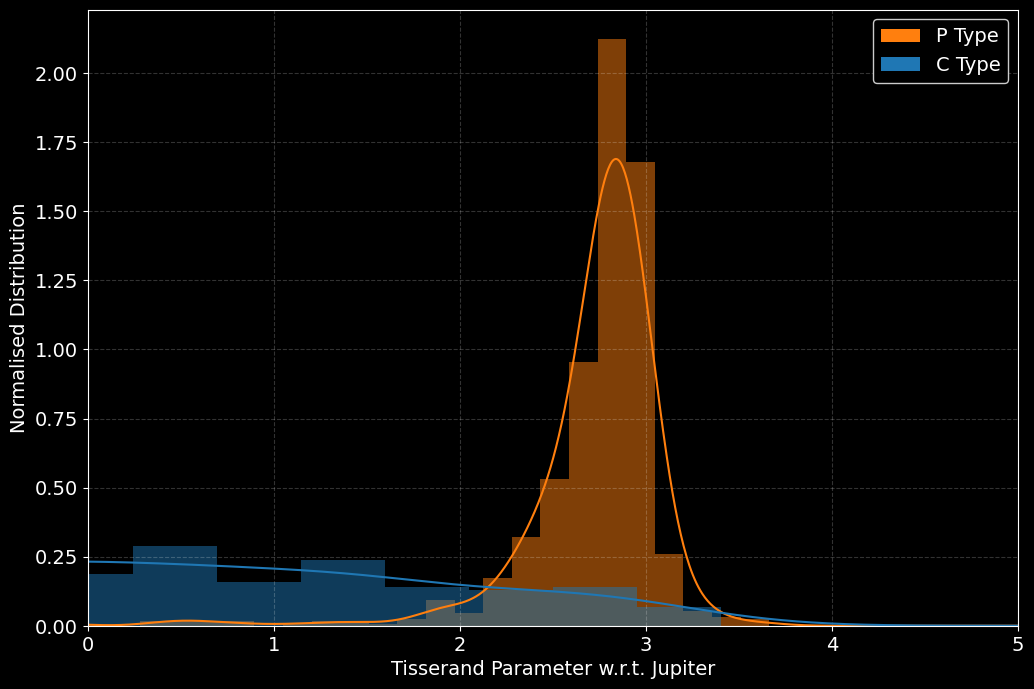

In [ ]:
# Square-root choice for the histograms number of bins
nr_of_bins = lambda data_array: int(np.floor(np.sqrt(len(data_array))))

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Histogram of the P and C type comets' Tisserand parameter.
ax.hist(p_type_df['TISSERAND_JUP'], \
        bins=nr_of_bins(p_type_df['TISSERAND_JUP']), \
        density=True, color='tab:orange', alpha=0.5, label='P Type')

ax.hist(c_type_df['TISSERAND_JUP'], \
        bins=nr_of_bins(c_type_df['TISSERAND_JUP']), \
        density=True, color='tab:blue', alpha=0.5, label='C Type')

# Plot the KDE of the P type comets
ax.plot(tisserand_range, p_type_tisr_distr, color='tab:orange', alpha=1, linestyle='solid')

# Plot the KDE of the C type comets
ax.plot(tisserand_range, c_type_tisr_distr, color='tab:blue', alpha=1, linestyle='solid')

# Set an x axis limits
ax.set_xlim(0, 5)

# Add a grid for better readability
ax.grid(axis='both', linestyle='dashed', alpha=0.2)

# Set an x and y label
ax.set_xlabel('Tisserand Parameter w.r.t. Jupiter')
ax.set_ylabel('Normalised Distribution')

# Re-define the opacity (alpha value) of the markers / lines in the
# legend for better visibility
leg = ax.legend(fancybox=True, loc='upper right', framealpha=1)
for lh in leg.legend_handles:
    lh.set_alpha(1)

# Save the figure
plt.savefig('comets_kde_tisserand_jup.png', dpi=300) 